## Options and Libraries

In [50]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [51]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()

## Read data

In [52]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb


# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies = df_full_dummies.drop(columns=[
    "response",
    "income_pred",
    "year_birth",
    "income_error", 
    "income_error_relative"
])

df_sel_dummies = df_full_dummies.drop(columns=[
    "id",
    
    #"marital_status_Divorced",
    "marital_status_Married",
    "marital_status_Single",
    "marital_status_Together",
    "marital_status_Widow",

    #"education_Basic",
    "education_2n Cycle",
    "education_Graduation",
    "education_Master",
    "education_PhD",

    #"mnt_wines",
    #"mnt_fruits",
    #"mnt_meat",
    #"mnt_fish",
    #"mnt_sweet",
    #"mnt_gold",
    
    #"num_deals",
    #"num_web",
    #"num_catalog",
    #"num_store",
    #"num_web_visits_month",
    
    "accepted_cmp1",
    "accepted_cmp2",
    "accepted_cmp3",
    "accepted_cmp4",
    "accepted_cmp5",
    "accepted_any",
    #"accepted_total",

    "dt_customer",
    #"recency",
    "complain",
    ],
    inplace=False)

In [53]:
# dropping some columns for "more targeted model"
regex_drop = r"error"
drop_cols = df_sel_dummies.filter(regex=regex_drop).columns

print(drop_cols)
df_sel_dummies.drop(columns=drop_cols, inplace=True)

Index([], dtype='object')


In [54]:
def visualize_selected_features(df, features, target_var=None, nrows=5, ncols=5, figsize=(20, 20)):
    """
    Visualizes selected features of a DataFrame grouped by a target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataset.
    - features (list): A list of feature names to visualize.
    - target_var (str): The column name of the target variable
    - nrows (int): Number of rows in the subplot grid. Default is 5.
    - ncols (int): Number of columns in the subplot grid. Default is 5.
    - figsize (tuple): Size of the overall figure. Default is (20, 20).
    """
    # Define the figure and axes for the grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
       
    # Loop over each feature and plot based on its type
    for i, feature in enumerate(features):
        if i >= len(axes):  # Skip plotting if axes are exhausted
            break
        
        if df[feature].dtype in ["float64", "int64"] and df[feature].max() > 0:  # Numerical features
            sns.histplot(data=df, x=feature, hue=target_var, kde=True, ax=axes[i])

        elif df[feature].dtype in ["category", "object"]:  # Nominal features
            sns.countplot(data=df, x=feature, hue=target_var, ax=axes[i])

        else:  # Ordinal or other types
            sns.violinplot(data=df, x=target_var, y=feature, ax=axes[i])
        
        # Set the title for the plot
        axes[i].set_title(feature)
        # axes[i].set_yscale("log")  
        axes[i].set(xlabel=None, ylabel=None)
    
    # Hide any remaining unused axes in the grid
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])
    

    plt.tight_layout()
    plt.show()

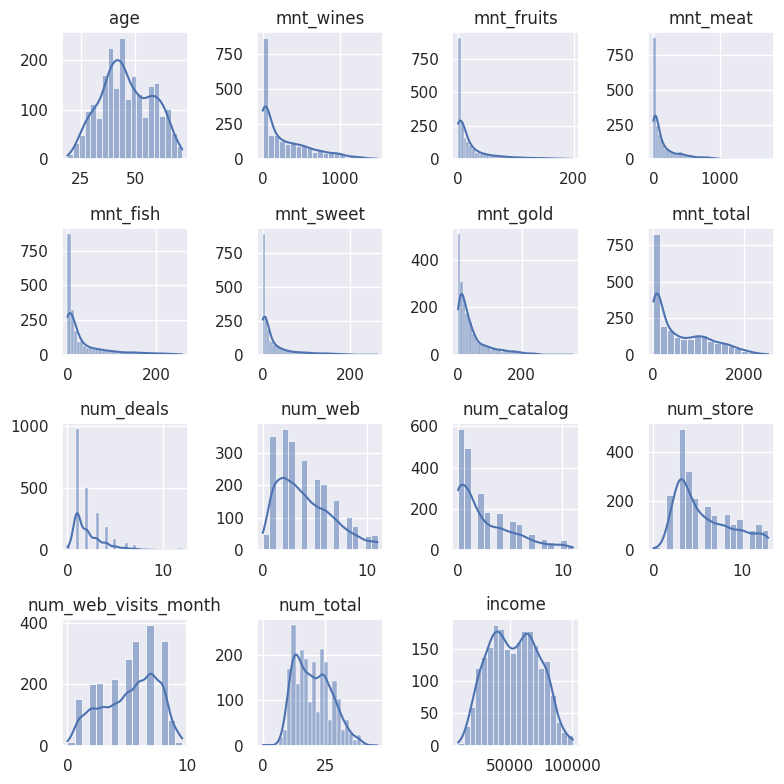

In [55]:
num_features = [
    "age",
    
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat",
    "mnt_fish",
    "mnt_sweet",
    "mnt_gold",
    "mnt_total",
    "num_deals", 
    "num_web", 
    "num_catalog", 
    "num_store", 
    "num_web_visits_month",
    "num_total", 
    "income", 
]

# Call the function for specific features
visualize_selected_features(
    df=df_full_dummies,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

## Evaluate Clustering Algorithms

In [56]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

def evaluate_clustering(model_class, X, k_range, **model_kwargs):
    """
    Evaluates clustering models for a range of cluster numbers.
    """
    results = []
    
    for k in k_range:
        # Instantiate the clustering model with the current number of clusters
        model = model_class(k, **model_kwargs) 
        
        # Fit the model and predict labels
        model.fit(X)
        labels = model.labels_ if hasattr(model, "labels_") else model.predict(X)
        
        # Compute clustering statistics
        stats = {
            "k": k,
            "silhouette_score ↑": silhouette_score(X, labels),
            "calinski_harabasz_score ↑": calinski_harabasz_score(X, labels),
            "davies_bouldin_score ↓": davies_bouldin_score(X, labels),
        }
        results.append(stats)
    
    # Convert results into a DataFrame
    return pd.DataFrame(results).style.hide()


In [36]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_sel_dummies)
df_scaled = pd.DataFrame(df_scaled, columns = df_sel_dummies.columns)
df_scaled.head(6)

,education_years,income,kidhome,teenhome,age,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,mnt_total,num_total,accepted_total,marital_status_simple_Single
0,-0.350051,0.267877,-0.825218,-0.929894,0.985345,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.366793,1.491860,2.665261,-0.550785,0.740812,1.679417,1.621229,-0.439037,1.346874
1,-0.350051,-0.328028,1.032559,0.906934,1.235733,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168114,-1.157932,-0.591401,-1.166125,-0.123617,-0.961275,-1.258779,-0.439037,1.346874
2,-0.350051,0.948717,-0.825218,-0.929894,0.317643,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.703020,1.491860,-0.229549,1.295237,-0.555832,0.282673,0.661226,-0.439037,-0.742460
3,-0.350051,-1.323292,1.032559,-0.929894,-1.268149,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168114,-0.779390,-0.953252,-0.550785,0.308597,-0.918094,-0.847349,-0.439037,-0.742460
4,1.557769,0.275709,1.032559,-0.929894,-1.017761,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.436606,0.356235,0.132302,0.064556,-0.123617,-0.305254,0.524083,-0.439037,-0.742460
5,0.285889,0.488929,-0.825218,0.906934,0.150717,-1.143438,0.642051,0.394768,-0.305541,-0.687068,0.361924,-0.575619,-0.168114,0.734776,0.494153,1.295237,0.308597,0.183025,1.072656,-0.439037,-0.742460


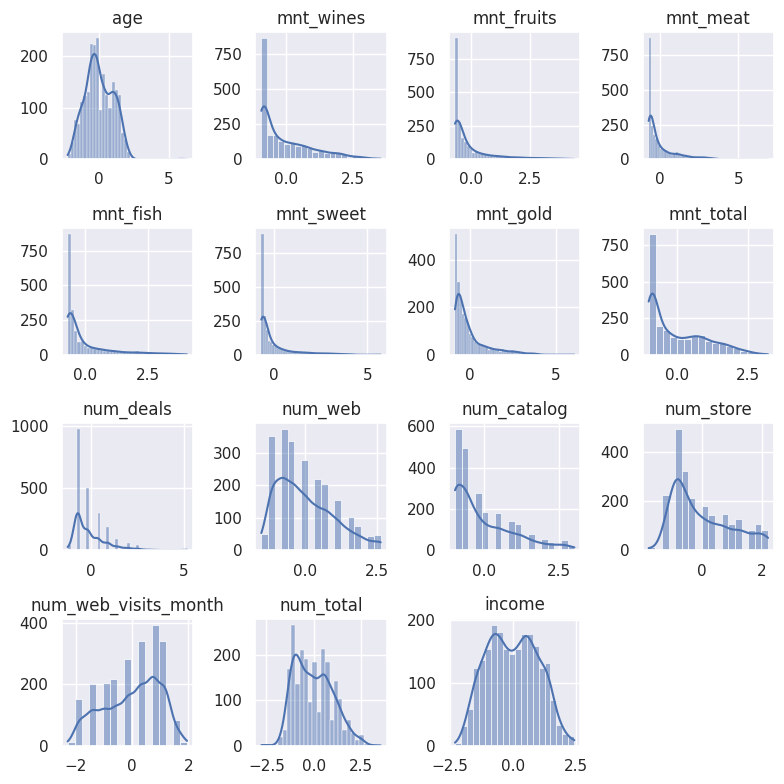

In [37]:
num_features = [
    "age",
    
    "mnt_wines",
    "mnt_fruits",
    "mnt_meat",
    "mnt_fish",
    "mnt_sweet",
    "mnt_gold",
    "mnt_total",
    "num_deals", 
    "num_web", 
    "num_catalog", 
    "num_store", 
    "num_web_visits_month",
    "num_total", 
    "income", 
]

# Call the function for specific features
visualize_selected_features(
    df=df_scaled,
    features=num_features,
    nrows=4, 
    ncols=4, 
    figsize=(8,8)
)

### K-Means

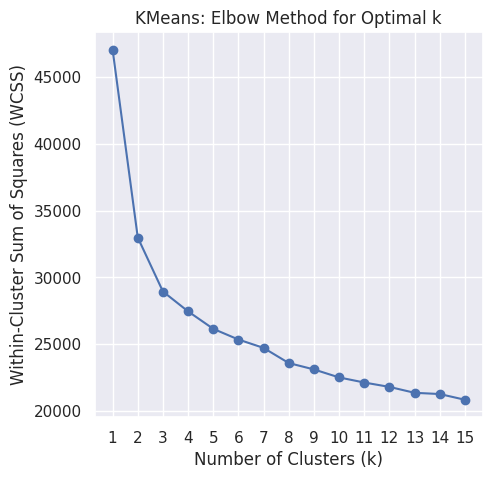

In [39]:
from sklearn.cluster import KMeans

# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 15+1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++", max_iter=1000)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(5, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("KMeans: Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

WCSS: measures the sum of squared distances between each data point and the centroid of its assigned cluster. 

In [40]:
# Evaluate KMeans
from sklearn.cluster import KMeans

kmeans_stats = evaluate_clustering(KMeans, df_scaled, range(2, 10), random_state=42, init="k-means++", max_iter=111)
print("KMeans Results:")
kmeans_stats

KMeans Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.286960,953.064769,1.488984
3,0.222352,698.871857,1.821890
4,0.130341,531.327726,2.102348
5,0.126456,446.064513,2.276044
6,0.117118,382.028339,2.363767
7,0.103989,335.719658,2.324294
8,0.114778,316.734229,2.300645
9,0.100899,288.493817,2.369639


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


### Gaussian Mixture

In [41]:
# Evaluate Gaussian Mixture
from sklearn.mixture import GaussianMixture

gmm_stats = evaluate_clustering(GaussianMixture, df_scaled, range(2, 7), random_state=42)
print("Gaussian Mixture Results:")
gmm_stats


Gaussian Mixture Results:


k,silhouette_score ↑,calinski_harabasz_score ↑,davies_bouldin_score ↓
2,0.262103,857.812012,1.559739
3,0.183392,597.662338,2.154093
4,0.106428,332.255198,3.213098
5,0.082926,274.567056,3.154810
6,0.067126,234.521541,3.488520


- silhouette_score: goes from -1 to +1, higher is better defined clusters
- calinski_harabasz_score: a ratio, higher is better
- davies_bouldin_score: lower is better, minimum value is 0


#### Results of comparison 

- Not unambiguous when comparing across and within algorithms:
  - gaussian mixture has better silhouette, worse Calinski-Harabasz-Score and similar Davies-Bouldin-Score

## Clustering Algorithms

In [42]:
# for both models
n_clusters = 3

### a: Gaussian Mixture

In [43]:
df_scaled.columns

Index(['education_years', 'income', 'kidhome', 'teenhome', 'age', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog', 'num_store',
       'num_web_visits_month', 'mnt_total', 'num_total', 'accepted_total', 'marital_status_simple_Single'],
      dtype='object')

In [44]:
# gaussian mixture
from sklearn.mixture import GaussianMixture
np.random.seed(42)

# fit clustering algo
gmm = GaussianMixture(n_components=n_clusters)  # Specify the number of components
gmm.fit(df_scaled)
gmm_pred_proba_array = gmm.predict_proba(df_scaled)
df_pred_gmm = gmm.predict(df_scaled)

# merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_gausmx_pred_proba = pd.DataFrame(gmm_pred_proba_array, columns=column_names)
df_gausmx_pred_proba['pred_cluster'] = (df_pred_gmm+1) # add one to start at 1, not 0
df_gausmx_pred_proba.head()

,prob_cluster_1,prob_cluster_2,prob_cluster_3,pred_cluster
0,0.000000e+00,1.000000e+00,6.636437e-11,2
1,1.000000e+00,4.361997e-138,5.141113e-12,1
2,1.706309e-67,7.440703e-01,2.559297e-01,2
3,1.000000e+00,1.847042e-131,7.703090e-12,1
4,6.127441e-16,1.010912e-127,1.000000e+00,3


### b: KMEANS

In [45]:
np.random.seed(42)

# Fit KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++")
kmeans_model.fit(df_scaled)

# Predict probabilities for each cluster
kmeans_pred_proba_array = kmeans_model.transform(df_scaled)  # Distance to centroids
kmeans_pred_proba_array = 1 / (1 + kmeans_pred_proba_array)  # Convert distances to probabilities
kmeans_pred_proba_array /= kmeans_pred_proba_array.sum(axis=1, keepdims=True)  # Normalize
df_pred_kmeans = kmeans_model.labels_

# Merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_kmeans_pred_proba = pd.DataFrame(kmeans_pred_proba_array, columns=column_names)
df_kmeans_pred_proba['pred_cluster'] = (df_pred_kmeans + 1)  # Add one to start at 1, not 0
df_kmeans_pred_proba.head(6)

,prob_cluster_1,prob_cluster_2,prob_cluster_3,pred_cluster
0,0.246086,0.424693,0.329221,2
1,0.490482,0.217893,0.291624,1
2,0.261973,0.368045,0.369982,3
3,0.540069,0.199992,0.259939,1
4,0.341994,0.283633,0.374373,3
5,0.260113,0.284537,0.455350,3


In [46]:
def reorder_clusters(df, cluster_col='pred_cluster', order_by='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[order_by].mean().sort_values(ascending=True)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = []  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc



## PICK model df

In [47]:
# pick winner (comment out the other)
x_winner = df_kmeans_pred_proba
#x_winner = df_gausmx_pred_proba

# make sure same number of rows for df and predictions
assert df_scaled.shape[0]==gmm_pred_proba_array.shape[0]

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_scaled.reset_index(drop=True),
    x_winner.reset_index(drop=True)], axis=1, ignore_index=False)

# reorder the cluster by: 
order_by = "income" # mnt_total is also a good one
order_by = "mnt_total" # mnt_total is also a good one
df_predicted = reorder_clusters(df_predicted, order_by=order_by)

df_predicted.groupby("pred_cluster").mean()

,education_years,income,kidhome,teenhome,age,recency,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,mnt_total,num_total,accepted_total,marital_status_simple_Single,_prob_1,_prob_2,_prob_3
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.146342,-0.796071,0.615543,-0.112346,-0.217709,0.010662,-0.781859,-0.532971,-0.638080,-0.547860,-0.526880,-0.546213,-0.198518,-0.750216,-0.750364,-0.784946,0.440777,-0.844447,-0.824888,-0.312617,0.004306,0.473466,0.299726,0.226808
2,0.244614,0.235022,-0.333979,0.756809,0.319382,-0.041135,0.448660,-0.085019,-0.140957,-0.138901,-0.103337,0.309426,0.854553,0.871876,0.145059,0.582270,0.265805,0.199433,0.936172,-0.063342,-0.059408,0.298371,0.407906,0.293723
3,-0.001274,1.175895,-0.744864,-0.615282,0.046172,0.025261,0.919733,1.048921,1.298070,1.133829,1.057758,0.646863,-0.566054,0.406008,1.190936,0.781034,-1.078528,1.301194,0.470697,0.629795,0.056403,0.259733,0.321380,0.418888


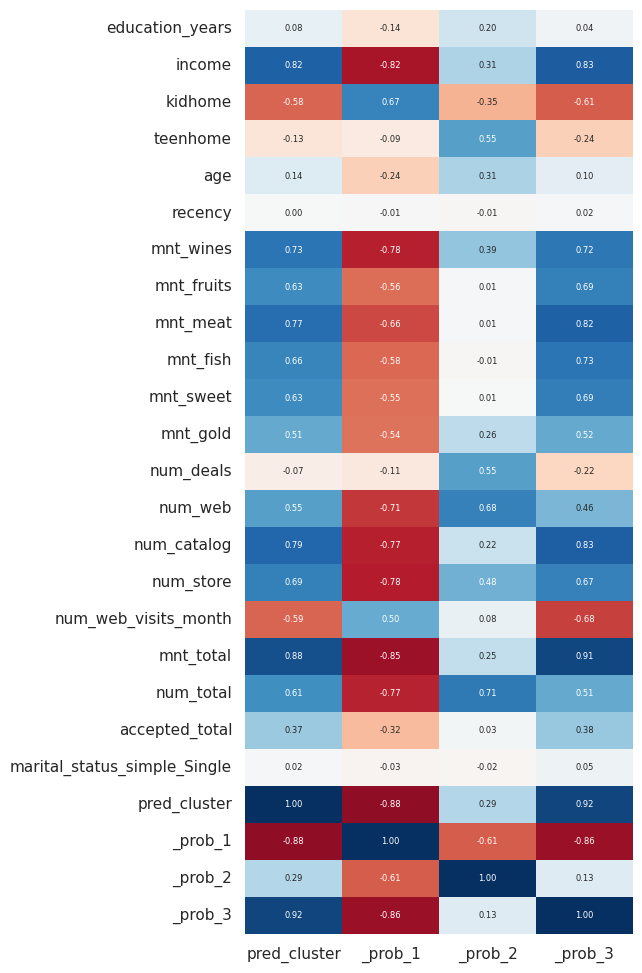

In [48]:
# get correlations 
df_predicted_encoded = pd.get_dummies(df_predicted, drop_first=False)
df_corr = df_predicted_encoded.corr()
df_corr_toplot = df_corr.filter(regex="prob|pred|pca|pred_cluster", axis=1)
#df_corr_toplot = df_corr.drop(regex="pred", axis=0)
#df_corr_toplot.drop(columns="pred_cluster", axis=1, inplace=True)
# heatmap
from matplotlib import pyplot as plt
import seaborn as sns

def heatmap(df, file_name=None, figsize=(10,5)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap='RdBu',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 6},
        vmin=-1, vmax=1,
        cbar=False
    )

    if file_name is not None:
        # save the plot as JPG file
        #print(f"saving {file_name}")
        plt.savefig(
            file_name,
            dpi=300,
            bbox_inches='tight'
        )
        #plt.xticks(rotation=0)
        plt.show()


heatmap(df_corr_toplot,
    file_name=f"output/figures/fig_corrplot_first_look_{n_clusters}_clst_income_pred.png",
    figsize=(5,12)
)

In [24]:
# df_predicted.value_counts("pred_custer")#
df_predicted["pred_cluster"].value_counts()

pred_cluster
1    1052
2     619
3     569
Name: count, dtype: int64

gmm logged
```
logged mnts pred_cluster
1     911
2     176
3    1153


k means, not logged
```
pred_cluster
1    1052
2     619
3     569
Name: count, dtype: int64
```

## PCA

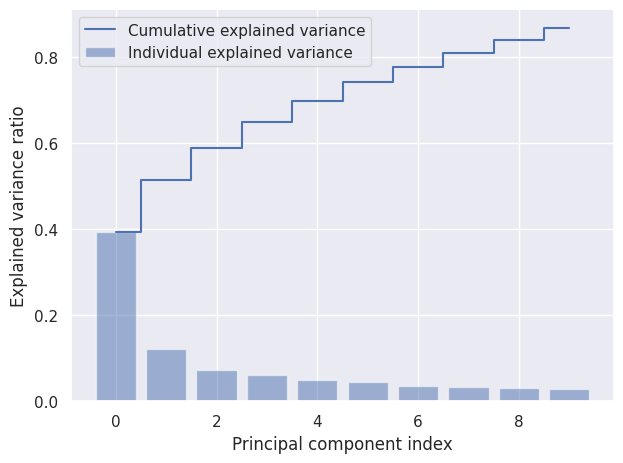

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit_transform(df_scaled)

exp_var_pca_sng = pca.explained_variance_ratio_
exp_var_pca_sum = np.cumsum(pca.explained_variance_ratio_)

plt.bar(range(0,len(exp_var_pca_sng)), exp_var_pca_sng, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca_sum)), exp_var_pca_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [26]:
df_pca =  df_scaled.copy()
df_pca["pca_1"]  = df_scaled.dot(pca.components_[0])
df_pca["pca_2"] = df_scaled.dot(pca.components_[1])
df_pca["pca_3"]  = df_scaled.dot(pca.components_[2])
df_pca["pca_4"] = df_scaled.dot(pca.components_[3])

# merge predictions onto pca dataset
df_pca = pd.merge(
    df_pca.reset_index(),
    df_predicted.reset_index(),
    left_index=False,
    right_index=False,
    how="inner"
).drop(columns=["index"])
df_pca

,education_years,income,kidhome,teenhome,age,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,num_deals,num_web,num_catalog,num_store,num_web_visits_month,mnt_total,num_total,accepted_total,marital_status_simple_Single,pca_1,pca_2,pca_3,pca_4,pred_cluster,_prob_1,_prob_2,_prob_3
0,-0.350051,0.267877,-0.825218,-0.929894,0.985345,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.366793,1.491860,2.665261,-0.550785,0.740812,1.679417,1.621229,-0.439037,1.346874,4.364019,0.139938,-1.564081,-0.770100,3,0.245843,0.331853,0.422304
1,-0.350051,-0.328028,1.032559,0.906934,1.235733,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168114,-1.157932,-0.591401,-1.166125,-0.123617,-0.961275,-1.258779,-0.439037,1.346874,-2.801670,-0.308655,1.298714,-0.920435,1,0.493869,0.288558,0.217573
2,-0.350051,0.948717,-0.825218,-0.929894,0.317643,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.703020,1.491860,-0.229549,1.295237,-0.555832,0.282673,0.661226,-0.439037,-0.742460,1.941144,-0.157146,-0.231241,-0.617964,2,0.260094,0.373238,0.366668
3,-0.350051,-1.323292,1.032559,-0.929894,-1.268149,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168114,-0.779390,-0.953252,-0.550785,0.308597,-0.918094,-0.847349,-0.439037,-0.742460,-2.965100,-1.025052,-0.969665,0.538499,1,0.554450,0.250937,0.194613
4,1.557769,0.275709,1.032559,-0.929894,-1.017761,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.436606,0.356235,0.132302,0.064556,-0.123617,-0.305254,0.524083,-0.439037,-0.742460,-0.196595,0.607789,-0.747209,0.721912,2,0.343633,0.378980,0.277387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.350051,0.423750,-0.825218,0.906934,0.150717,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,-0.168114,1.870401,0.132302,-0.550785,-0.123617,1.221032,0.386940,-0.439037,-0.742460,2.887382,0.889708,-1.062913,-1.306175,2,0.269313,0.369172,0.361515
2236,1.557769,0.564769,2.890335,0.906934,1.903435,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,2.506420,1.491860,-0.229549,-0.243114,0.740812,-0.268717,1.209799,1.035390,-0.742460,-0.733232,3.921141,0.570607,1.293895,2,0.331451,0.398307,0.270242
2237,-0.350051,0.209418,-0.825218,-0.929894,-1.017761,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,-0.703020,-0.779390,0.132302,2.218248,0.308597,1.054951,0.661226,1.035390,1.346874,1.849096,-0.575771,-0.330017,1.697620,3,0.283514,0.349450,0.367036
2238,0.285889,0.829071,-0.825218,0.906934,1.068807,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,-0.168114,0.734776,0.856004,1.295237,-0.988047,0.393948,0.798370,-0.439037,-0.742460,2.207566,0.867134,1.083050,-1.162769,2,0.232768,0.422179,0.345053


In [27]:
# plot opts
sns.set_theme()
p_pal = sns.color_palette("viridis", as_cmap=True)
p_alpha = 1

<Axes: xlabel='pca_1', ylabel='pca_4'>

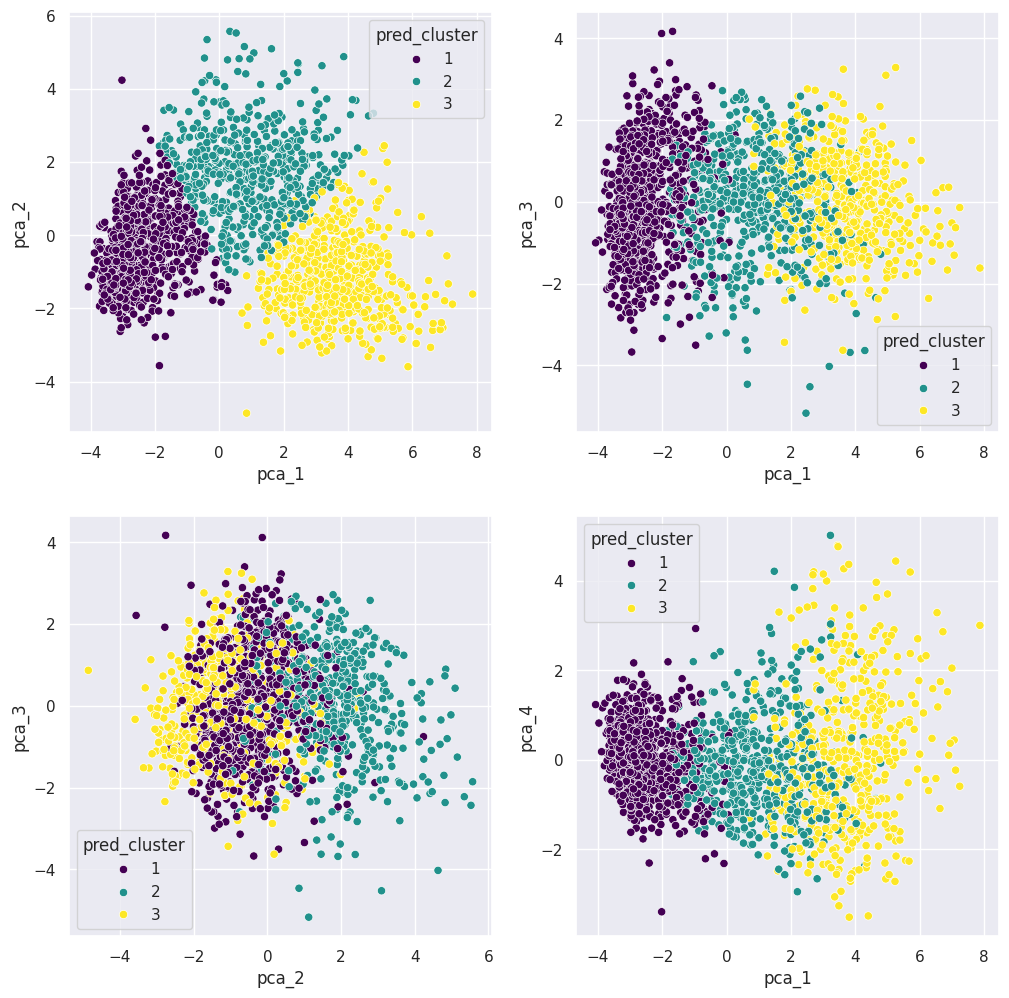

In [28]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_2", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,2)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_3", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,3)
sns.scatterplot(data=df_pca, x="pca_2", y="pca_3", hue="pred_cluster", alpha=p_alpha, palette=p_pal)
ax = plt.subplot(2,2,4)
sns.scatterplot(data=df_pca, x="pca_1", y="pca_4", hue="pred_cluster", alpha=p_alpha, palette=p_pal)

<Axes: xlabel='pca_2', ylabel='income'>

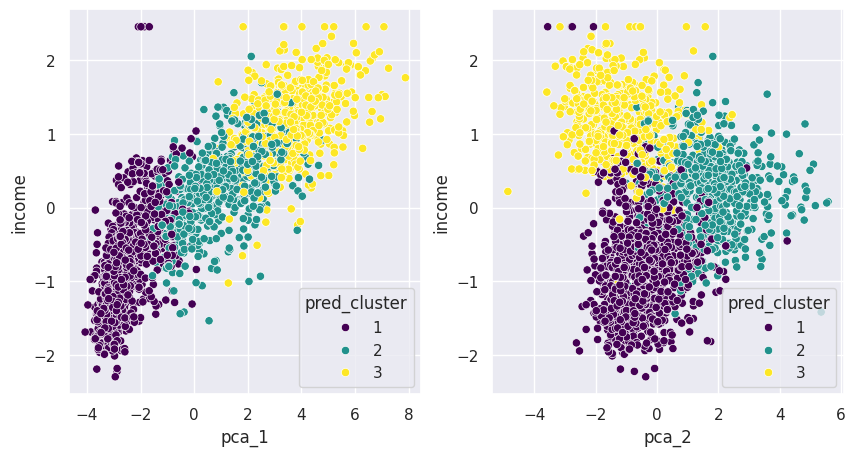

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_pca, x="pca_1", y="income", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_pca, x="pca_2", y="income", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

<Axes: xlabel='mnt_total', ylabel='pca_1'>

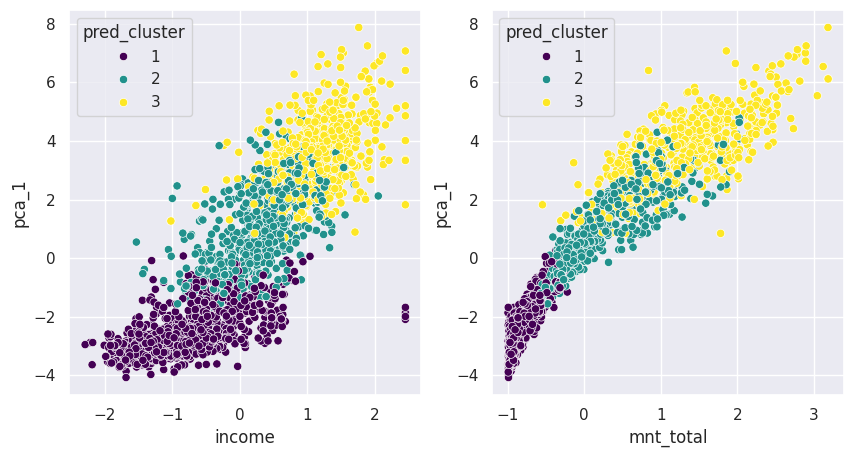

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_pca, x="income", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_pca, x="mnt_total", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

<Axes: xlabel='num_web', ylabel='pca_1'>

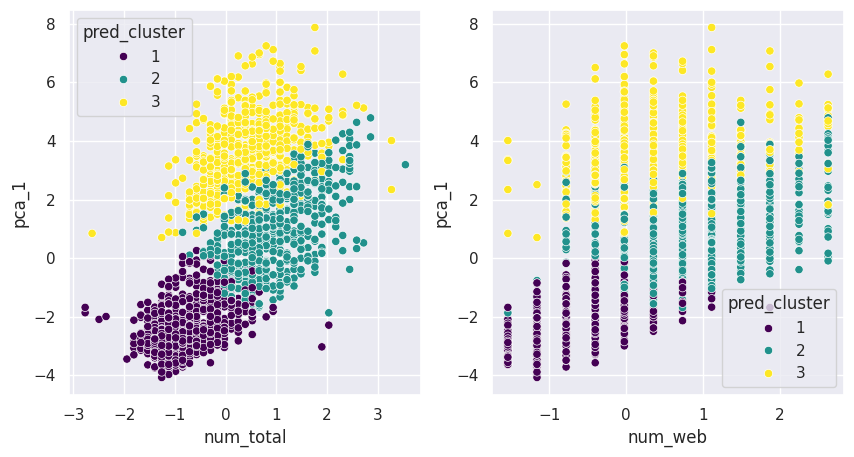

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_pca, x="num_total", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_pca, x="num_web", y="pca_1", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

In [ ]:
dftoplot = df_pca.filter(regex="_prob|pca|pred|pro", axis=1)
dftoplot.columns

### Correlation matrix with PCA

In [ ]:
dftoplot = df_pca.corr().filter(regex="_prob|pca|pro", axis=1)
dftoplot = dftoplot.drop(index=df_pca.filter(regex="_prob|pca|pred", axis=1).columns, axis=0)
heatmap(dftoplot, figsize=(6,12))

## Summary Stats

In [264]:
def summary_stats_by_group(df, group_var, target_var, sorted=False):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p05=lambda x: x.quantile(0.05),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    ).reset_index()

    # Sort by mean value (descending order)
    if sorted: summary = summary.sort_values(by="mean", ascending=True)

    return summary.style.hide()

In [ ]:
print("income")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income")

In [ ]:
print("num_web")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web")

In [ ]:
print("num_web_visits_month")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="num_web_visits_month")

In [ ]:
print("age")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="age")

In [ ]:
print("income")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="income")

In [ ]:
print("mnt_wines")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_wines")

In [ ]:
print("mnt_fruits")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_fruits")

In [ ]:
print("mnt_total")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="mnt_total")

In [ ]:
print("accepted_total")
summary_stats_by_group(df_predicted_encoded, group_var="pred_cluster", target_var="accepted_total")

In [276]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_strip_matrix_auto(df, group_var, target_vars, figsize=(9, 7), jitter=True, cut=0):
    """
    Creates a matrix of violin and strip plots for multiple target variables,
    with rows and columns determined automatically.
    """
    num_vars = len(target_vars)
    cols = math.ceil(math.sqrt(num_vars))  # Number of columns
    rows = math.ceil(num_vars / cols)     # Number of rows

    # Create the grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, target_var in enumerate(target_vars):
        if i < len(axes):
            ax = axes[i]  # Select subplot
            sns.violinplot(
                x=target_var, y=group_var, data=df, cut=cut, ax=ax, hue=group_var
            )
            if jitter:
                sns.stripplot(
                    x=target_var, y=group_var, data=df,
                    color="black", size=3, alpha=0.1, jitter=0.2, ax=ax
                )
            ax.set_title(f"Distribution of {target_var}")
            ax.set(xlabel=None, ylabel=None)
        else:
            axes[i].axis("off")  # Hide unused subplots

    # Turn off any remaining unused subplots
    for i in range(num_vars, len(axes)):
        axes[i].axis("off")

    plt.show()


In [63]:
df_predicted_encoded['pred_cluster_cat'] = pd.Categorical(df_predicted_encoded["pred_cluster"])

In [64]:
df_predicted_encoded.columns

Index(['education_years', 'income', 'kidhome', 'teenhome', 'age', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'num_deals', 'num_web', 'num_catalog', 'num_store',
       'num_web_visits_month', 'mnt_total', 'num_total', 'accepted_total', 'marital_status_simple_Single', 'pred_cluster', '_prob_1', '_prob_2', '_prob_3', 'pred_cluster_cat'],
      dtype='object')

In [66]:
target_vars = ["income", "mnt_total", "age",  "num_web_visits_month"]
plot_violin_strip_matrix_auto(df_uns, group_var='pred_cluster_cat', target_vars=target_vars)

NameError: name 'plot_violin_strip_matrix_auto' is not defined

In [ ]:
target_vars = ['accepted_cmp1', 'accepted_cmp2', 'accepted_cmp2', 'accepted_cmp4', 'accepted_cmp5', 'accepted_total', 'accepted_any']
target_vars = ['accepted_total', 'accepted_any']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['kidhome', 'teenhome']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)

In [ ]:
target_vars = ['num_deals', 'num_web', 'num_catalog', 'num_store', 'num_web_visits_month']
plot_violin_strip_matrix_auto(df_predicted_encoded, group_var='pred_cluster_cat', target_vars=target_vars)